In [70]:
from gurobipy import Model, GRB, GurobiError
import matplotlib.pyplot as plt
import numpy as np

In [71]:
n = 50
V = range(n)
xs = np.random.uniform(low=0, high=100, size=n)
ys = np.random.uniform(low=0, high=100, size=n)

cost = {
    (i, j): (xs[i] - xs[j]) ** 2 + (ys[i] - ys[j]) ** 2
    for i in V for j in V if i != j
}

A = list(cost.keys())

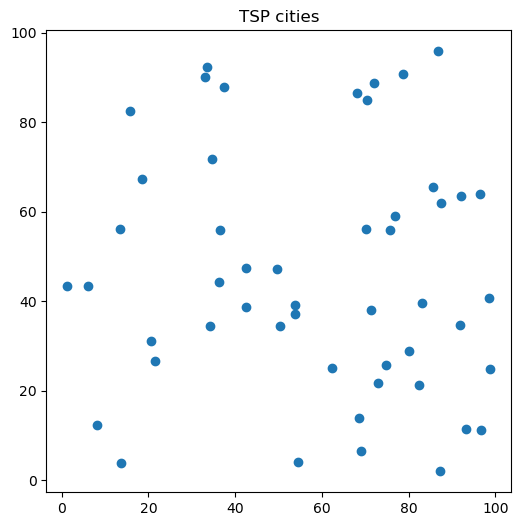

In [72]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(xs, ys)
ax.set_title('TSP cities');

In [73]:
m = Model()
x = m.addVars(A, vtype=GRB.BINARY, name='x', obj=cost)
m.addConstrs((x.sum(i, '*') == 1 for i in V), name='out_degree')
m.addConstrs((x.sum('*', i) == 1 for i in V), 'in_degree');

In [74]:
m.setParam(GRB.Param.LazyConstraints, 1)

Set parameter LazyConstraints to value 1


In [75]:
def add_sec_for(subtour):
    print('Added a violated SEC')
    m.cbLazy(sum(x[i, j] for i in subtour for j in set(V) - set(subtour)) >= 1)

In [76]:
def next_after(i):
    for j in V:
        if j == i:
            continue
        try:
            if m.cbGetSolution(x[i, j]) > 0.9:
                return j
        except GurobiError:
            if x[i, j].X > 0.9:
                return j
    
    assert False, f"Vertex {i} has no successor"

In [77]:
def subtour_starting_at(vertex):
    tour = [vertex]
    current = next_after(vertex)

    while current != vertex:
        tour.append(current)
        current = next_after(current)

    return tour

In [78]:
def callback(what, where):
    if where != GRB.Callback.MIPSOL:
        return

    remaining = set(V)

    while len(remaining) > 0:
        current = next(iter(remaining))
        subtour = subtour_starting_at(vertex=current)

        if len(subtour) == n:
            return
        
        add_sec_for(subtour)

        remaining -= set(subtour)

In [79]:
m.optimize(callback)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 100 rows, 2450 columns and 4900 nonzeros
Model fingerprint: 0x5e6a733d
Variable types: 0 continuous, 2450 integer (2450 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 1e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 153973.39328
Presolve time: 0.02s
Presolved: 100 rows, 2450 columns, 4900 nonzeros
Variable types: 0 continuous, 2450 integer (2450 binary)

Root relaxation: objective 4.582499e+03, 86 iterations, 0.00 seconds (0.00 work units)
Added a violated SEC
Added a violated SEC
Added a violated SEC
Added a violated SEC
Added a violated SEC
Added a violated SEC
Added a violated SEC
Added a violated SEC
Added a violated SEC
Added a violate

In [80]:
tour = subtour_starting_at(0)

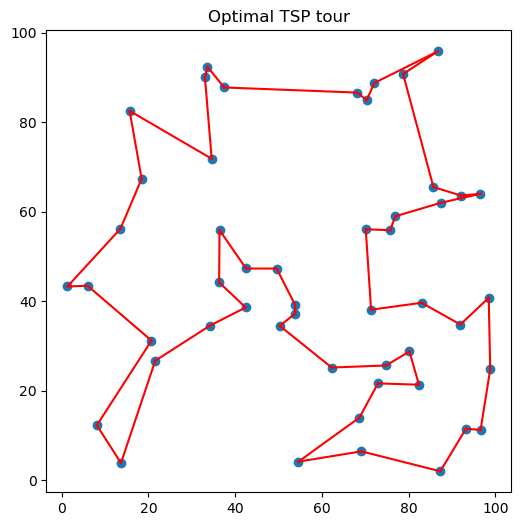

In [82]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(xs, ys)
tour2 = tour[1:] + [0]

for i, j in zip(tour, tour2):
    ax.plot((xs[i], xs[j]), (ys[i], ys[j]), color='red')

ax.set_title('Optimal TSP tour');